## Intrusion Detection Packet Classification by type of attacks
### Capston B

In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf 
import matplotlib as matplot
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize

Using TensorFlow backend.


Preprocessing -Transformation and Scaling 

In [2]:
#tf version
import tensorflow as tf
tf.__version__
#tensorboard version
from tensorboard import version; print(version.VERSION)
#Keras version
import keras 
keras.__version__

'1.14.0'

1.14.0


'2.3.1'

In [ ]:
#tesnsor flow version should be '1.14.0'
#tensorboard version should be 1.14.0
#Keras version was '2.3.1'

In [3]:
import os
import pandas as pd
os.chdir('C:\\Users\\Brook\\Desktop\\#SMU_Courses\\#MSDS 6130 Capstone A & B\\MSDS6120 CapstoneA\\#ProjectData&NoteBook')

In [4]:
print ( "Current working dir : %s" % os.getcwd())

Current working dir : C:\Users\Brook\Desktop\#SMU_Courses\#MSDS 6130 Capstone A & B\MSDS6120 CapstoneA\#ProjectData&NoteBook


In [5]:
pd.set_option('display.max_columns', None)

In [6]:
train = pd.read_csv(r'UNSW_NB15_training_set.csv')
test = pd.read_csv(r'UNSW_NB15_testing_set.csv')
list_events = pd.read_csv(r'UNSW_NB15_LIST_EVENTS.csv')
features = pd.read_csv(r'UNSW_NB15_features.csv',encoding='latin1')

In [7]:
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

Function to encode string features

In [8]:
le1 = LabelEncoder()
le = LabelEncoder()

vector = combined_data['attack_cat']

print("attack cat:", set(list(vector))) # use print to make it print on single line 

combined_data['attack_cat'] = le1.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

vector = combined_data['attack_cat']
print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode())
print("mode", len(np.where(vector.values==6)[0])/len(vector),"%")
print("looks like 6 is 'normal', but its not that common")

attack cat: {'Backdoor', 'DoS', 'Shellcode', 'Reconnaissance', 'Worms', 'Analysis', 'Fuzzers', 'Generic', 'Normal', 'Exploits'}

Describing attack_type: 
min 0
max 9
mode 0    6
dtype: int32
mode 0.3609225646458884 %
looks like 6 is 'normal', but its not that common


In [9]:
le1.inverse_transform([0,1,2,3,4,5,6,7,8,9,])

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

???? Dropping thr features of Low Standard deviation and Low corr

In [10]:
##?????
lowSTD = list(combined_data.std().to_frame().nsmallest(6,columns=0).index)
lowCORR = list(combined_data.corr().abs().sort_values('attack_cat')['attack_cat'].nsmallest(3).index) # .where(lambda x: x < 0.005).dropna()
drop = set( lowCORR + lowSTD)
#drop = {'ackdat', 'ct_ftp_cmd', 'djit', 'is_ftp_login', 'is_sm_ips_ports', 'response_body_len', 'sjit', 'synack', 'tcprtt'}
combined_data.shape
combined_data_reduced=combined_data.drop(drop,axis=1)
combined_data_reduced.shape

(257673, 44)

(257673, 35)

In [11]:
pd.set_option('display.max_columns', None)
combined_data_reduced.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,swin,stcpb,dtcpb,dwin,smean,dmean,trans_depth,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,attack_cat,label
0,0.121478,113,0,4,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,255,621772692,2202533631,255,43,43,0,1,0,1,1,1,1,0,1,1,6,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,255,1417884146,3077387971,255,52,1106,0,43,1,1,1,1,2,0,1,6,6,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,255,2116150707,2963114973,255,46,824,0,7,1,2,1,1,3,0,2,6,6,0
3,1.681642,113,3,4,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,255,1107119177,1047442890,255,52,64,0,1,1,2,1,1,3,0,2,1,6,0
4,0.449454,113,0,4,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,255,2436137549,1977154190,255,53,45,0,43,1,2,2,1,40,0,2,39,6,0


In [12]:
lowSTD 

['ackdat', 'synack', 'tcprtt', 'is_ftp_login', 'ct_ftp_cmd', 'is_sm_ips_ports']

In [13]:
#https://stats.stackexchange.com/questions/309612/removing-features-with-low-variance-in-classification-models
lowCORR

['sjit', 'response_body_len', 'djit']

In [14]:
## ??????
transform = list(combined_data_reduced.columns.values[4:])
#transform

['spkts',
 'dpkts',
 'sbytes',
 'dbytes',
 'rate',
 'sttl',
 'dttl',
 'sload',
 'dload',
 'sloss',
 'dloss',
 'sinpkt',
 'dinpkt',
 'swin',
 'stcpb',
 'dtcpb',
 'dwin',
 'smean',
 'dmean',
 'trans_depth',
 'ct_srv_src',
 'ct_state_ttl',
 'ct_dst_ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'ct_flw_http_mthd',
 'ct_src_ltm',
 'ct_srv_dst',
 'attack_cat',
 'label']

In [15]:
transform.append('dur')
transform.remove('attack_cat')
# transform min-max norm 
combined_data_reduced[transform] = combined_data_reduced[transform].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

Combined data reducd transformation

In [16]:
combined_data_reduced[transform]

,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,swin,stcpb,dtcpb,dwin,smean,dmean,trans_depth,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,label,dur
0,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,0.000000,0.000000,2.879598e-04,0.000145,1.0,0.144768,0.512828,1.0,0.012838,0.028667,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,2.024634e-03
1,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.992126,1.401989e-06,0.022458,0.000376,0.003087,5.916098e-04,0.000267,1.0,0.330128,0.716524,1.0,0.018919,0.737333,0.0,0.677419,0.166667,0.000000,0.000000,0.0,0.015625,0.0,0.000000,0.081967,0.0,1.083170e-02
2,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,0.000188,0.001090,2.748269e-03,0.001779,1.0,0.492706,0.689918,1.0,0.014865,0.549333,0.0,0.096774,0.166667,0.017241,0.000000,0.0,0.031250,0.0,0.016949,0.081967,0.0,2.705215e-02
3,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,0.000188,0.000545,1.811945e-03,0.001563,1.0,0.257772,0.243882,1.0,0.018919,0.042667,0.0,0.000000,0.166667,0.017241,0.000000,0.0,0.031250,0.0,0.016949,0.000000,0.0,2.802737e-02
4,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,0.000376,0.000182,5.659534e-04,0.001310,1.0,0.567209,0.460351,1.0,0.019595,0.030000,0.0,0.677419,0.166667,0.017241,0.017241,0.0,0.609375,0.0,0.016949,0.622951,0.0,7.490901e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,0.000000,1.389445e-02,0.000000,0.000000,0.000000,5.926172e-08,0.000000,0.0,0.000000,0.000000,0.0,0.018919,0.000000,0.0,0.000000,0.333333,0.017241,0.000000,0.0,0.015625,0.0,0.016949,0.000000,0.0,8.333335e-08
82328,0.001785,0.000726,0.001257,0.000024,0.000024,0.996078,0.992126,2.072552e-05,0.000100,0.001316,0.000182,6.623096e-04,0.002489,1.0,0.249720,0.764699,1.0,0.593919,0.029333,0.0,0.000000,0.166667,0.017241,0.000000,0.0,0.000000,0.0,0.033898,0.016393,0.0,1.843502e-02
82329,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,7.111492e-01,0.000000,0.0,0.000000,0.000000,0.0,0.014865,0.000000,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000e+00
82330,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,7.111493e-01,0.000000,0.0,0.000000,0.000000,0.0,0.014865,0.000000,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000e+00


In [17]:
data_x = combined_data_reduced.drop(['attack_cat','label'], axis=1) # droped label
data_y = combined_data_reduced.loc[:,['label']]

# del combined_data # free mem
# Use stratification to fix imbalance of normal vs. attack categories
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, train_size=0.8,test_size=0.2, random_state = 1, stratify = data_y)

#https://www.bitdegree.org/learn/train-test-split
#X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.70, random_state=42) # TODO

In [18]:
#combined_data_reduced[transform].head(5)

In [19]:
#data_x

In [20]:
#data_y

In [21]:
data_y.isnull().values.any()

False

In [22]:
is_all_zero = np.all((data_y == 0))
if is_all_zero:
    print('Array contains only 0')
else:
    print('Array has non-zero items too')


Array has non-zero items too


In [23]:
# after we split to 70 /30 to combine dataset

X_train.shape
y_train.shape
X_test.shape # test is larger... good 
y_test.shape

(206138, 33)

(206138, 1)

(51535, 33)

(51535, 1)

Benchmark before additional feature removal

In [24]:
#import xgboost 
#import lightgbm

# DTC = DecisionTreeClassifier()
# RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
# ETC = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)

# Feature selection methods deployed , DTC , RFC , ETC 
DTC = DecisionTreeClassifier() 
RFC = RandomForestClassifier(n_estimators=25, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_features='auto', bootstrap=False)


#XGB = xgboost.XGBClassifier(n_estimators=150, n_jobs=-1)
#GBM = lightgbm.LGBMClassifier(objective='binary', n_estimators= 500) # multiclass

list_of_CLFs_names = []
list_of_CLFs = [DTC, RFC, ETC]
#list_of_CLFs = [DTC, RFC, ETC, XGB, GBM]
ranking = []

for clf in list_of_CLFs:
    _ = clf.fit(X_train,y_train)
    pred = clf.score(X_test,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)

Acc: 0.94023 for the DecisionTreeClassifier
Acc: 0.94914 for the RandomForestClassifier
Acc: 0.94621 for the ExtraTreesClassifier


In [25]:
# mlxtend error fix,https://stackoverflow.com/questions/49889524/issues-importing-mlxtend-python
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from mlxtend.classifier import EnsembleVoteClassifier

https://medium.com/@jonathan_hui/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491

https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/

In [26]:
eclf = EnsembleVoteClassifier

In [27]:

#refe
#https://github.com/alik604/cyber-security/blob/master/Intrusion-Detection/UNSW_NB15.ipynb

#http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/


#eclf = VotingClassifier(clfs=list_of_CLFs, voting='soft')  #refit=False
eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, voting='soft')  #refit=False
_ = eclf.fit(X_train, y_train)
pred = eclf.score(X_test, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))
pred = eclf.predict(X_test)
probas = eclf.predict_proba(X_test)
plt.show()



Acc: 0.94561 for the EnsembleVoteClassifier


In [28]:
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA,TruncatedSVD,PCA
from sklearn.svm import LinearSVC
# Number of trees
n = 10

In [29]:
# rfe = RFE(DecisionTreeClassifier(), n).fit(X_train,y_train)

# desiredIndices = np.where(rfe.support_==True)[0]
# whitelist = X_train.columns.values[desiredIndices]
# X_train_RFE,X_test_RFE = X_train[whitelist],X_test[whitelist]


In [30]:
#Try RFE 

rfe = RFE(DecisionTreeClassifier(), n).fit(X_train, y_train)

desiredIndices = np.where(rfe.support_==True)[0]
whitelist = X_train.columns.values[desiredIndices]
X_train_RFE, X_test_RFE = X_train[whitelist], X_test[whitelist]

print('new shape', X_train_RFE.shape) 

for clf in list_of_CLFs:
    _ = clf.fit(X_train_RFE,y_train)
    pred = clf.score(X_test_RFE,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)


eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, voting='soft')  # refit=False,
_ = eclf.fit(X_train_RFE, y_train)
pred = eclf.score(X_test_RFE, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))


pred = eclf.predict(X_test_RFE)
probas = eclf.predict_proba(X_test_RFE)
plt.show()


new shape (206138, 10)
Acc: 0.93486 for the DecisionTreeClassifier
Acc: 0.94662 for the RandomForestClassifier
Acc: 0.94153 for the ExtraTreesClassifier
Acc: 0.94262 for the EnsembleVoteClassifier


In [31]:
X_train_RFE.head(5)

,dur,sbytes,dbytes,sttl,sloss,sinpkt,stcpb,smean,ct_dst_src_ltm,ct_srv_dst
41663,1.268267e-02,0.000036,0.000024,0.996078,0.000376,9.409076e-04,0.226597,0.019595,0.046875,0.049180
51111,1.833334e-07,0.000006,0.000000,0.996078,0.000000,1.303758e-07,0.000000,0.022297,0.031250,0.098361
156280,1.500000e-07,0.000006,0.000000,0.996078,0.000000,1.066711e-07,0.000000,0.022297,0.500000,0.524590
23748,8.328252e-03,0.001201,0.000024,0.996078,0.001316,2.990359e-04,0.215976,0.566892,0.125000,0.131148
133961,1.500000e-07,0.000006,0.000000,0.996078,0.000000,1.066711e-07,0.000000,0.022297,0.468750,0.491803


In [32]:
# Try SVD 

svd = TruncatedSVD(n_components=n).fit(X_train)
X_train_svd, X_test_svd = svd.transform(X_train), svd.transform(X_test)

for clf in list_of_CLFs:
    _ = clf.fit(X_train_svd, y_train)
    pred = clf.score(X_test_svd, y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)

eclf = EnsembleVoteClassifier(clfs=list_of_CLFs,  voting='soft') #refit=False,
_ = eclf.fit(X_train_svd, y_train)
pred = eclf.score(X_test_svd, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))


pred = eclf.predict(X_test_svd)
probas = eclf.predict_proba(X_test_svd)
plt.show()

Acc: 0.91338 for the DecisionTreeClassifier
Acc: 0.92508 for the RandomForestClassifier
Acc: 0.91881 for the ExtraTreesClassifier
Acc: 0.91901 for the EnsembleVoteClassifier


In [33]:
svd = TruncatedSVD(n_components=n-1).fit(X_train_RFE)   
X_train_svd, X_test_svd = svd.transform(X_train_RFE), svd.transform(X_test_RFE)

Benchmark after additional feature removal

In [34]:

DTC = DecisionTreeClassifier() 
RFC = RandomForestClassifier(n_estimators=25, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_features='auto', bootstrap=False)
eclf = VotingClassifier(estimators=[('DecisionTreeClassifier', DTC), ('RandomForestClassifier', RFC),('ExtraTreesClassifier',ETC)], voting='hard')
for clf, label in zip([DTC, RFC,ETC, eclf], ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'Ensemble']): 
        _ = eclf.fit(X_train_svd,y_train)
        pred = eclf.score(X_test_svd,y_test)
        print("Acc: %0.10f [%s]" % (pred,label))

Acc: 0.9327835452 [DecisionTreeClassifier]
Acc: 0.9322596294 [RandomForestClassifier]
Acc: 0.9333074609 [ExtraTreesClassifier]
Acc: 0.9320849908 [Ensemble]


In [35]:
print(X_train_svd.shape)

(206138, 9)


In [36]:
#X_train_svd

#### Deep Learning 

We ran  SVD/PCA to remove variance since the  goal to "get the better deep learning result possible"

In [37]:
from keras.models import Sequential


In [38]:
# ?? why transformation here

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_svd = mms.fit_transform(X_train_svd)
X_test_svd = mms.transform(X_test_svd)

In [39]:
X = X_train_svd
X_t = X_test_svd

dim = X.shape[1]
dim

9

In [40]:
#X

In [41]:
#X_t

In [42]:
#y_test

In [43]:
#THis is for dimensional change for BLSTM RNN
#X_v,y_v  = X_t[:X_t.shape[0]], y_test[:X_t.shape[0]]
#X_v ,y_v = X_t[:X_t.shape[0]/5], y_test[:X_t.shape[0]/5]

In [44]:
#X_v

In [45]:
#y_v

https://keras.io/guides/sequential_model/

The Keras library provides wrapper classes to allow you to use neural network models developed with Keras in scikit-learn.There is a KerasClassifier class in Keras that can be used as an Estimator in scikit-learn, the base type of model in the library. The KerasClassifier takes the name of a function as an argument. This function must return the constructed neural network model, ready for training.
https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
https://forums.fast.ai/t/multiclass-classification-using-dense-layers/216/5
https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

Define The Neural Network Model

In [46]:
classifier = Sequential()
# input layer
classifier.add(Dense(18, activation='relu', input_dim=dim))

# 3 hidden layers
classifier.add(Dense(36, activation='relu'))
classifier.add(Dropout(0.07))

classifier.add(Dense(18, activation='relu' ))
classifier.add(Dropout(0.07))

classifier.add(Dense(9, activation='relu'))
#out put layer 
classifier.add(Dense(1, activation='sigmoid'))
# optimizer 
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [47]:
#tensorboard = TensorBoard(histogram_freq=0,write_graph=True)
    
    
tensorboard = TensorBoard(log_dir=f".\logs\MODEL", histogram_freq=1,write_graph=True)

In [48]:
from tensorflow.keras import layers, Sequential

In [49]:
# Data voloume 77301 dataset
# the name tf.summary is deprecated. please use tf.compat.v1.summary instead
# if you get invalid argument error when run the model use 
#tf.reset_default_graph() 
#https://stackoverflow.com/questions/51872592/invalidargumenterror-you-must-feed-a-value-for-placeholder-tensor-placeholder


history = classifier.fit(X,y_train, batch_size=16, epochs=10, validation_data=(X_t,y_test) , callbacks=[tensorboard]).history


Train on 206138 samples, validate on 51535 samples



Epoch 1/10
206138/206138 [==============================] - 22s 108us/step - loss: 0.3067 - accuracy: 0.8753 - val_loss: 0.2580 - val_accuracy: 0.8890

Epoch 2/10
206138/206138 [==============================] - 21s 101us/step - loss: 0.2439 - accuracy: 0.8909 - val_loss: 0.2273 - val_accuracy: 0.8900
Epoch 3/10
206138/206138 [==============================] - 20s 98us/step - loss: 0.2208 - accuracy: 0.8957 - val_loss: 0.2022 - val_accuracy: 0.8988
Epoch 4/10
206138/206138 [==============================] - 20s 96us/step - loss: 0.2136 - accuracy: 0.8981 - val_loss: 0.2069 - val_accuracy: 0.8990
Epoch 5/10
206138/206138 [==============================] - 20s 96us/step - loss: 0.2094 - accuracy: 0.8998 - val_loss: 0.1911 - val_accuracy: 0.9077
Epoch 6/10
206138/206138 [==============================] - 25s 119us/step - loss: 0.2046 - accuracy: 0.9022 - val_loss: 0.1934 - val_accuracy: 0.9079
Epoch 7/10
206138/206138 [===============

In [50]:
#pip install keras_sequential_ascii
from keras_sequential_ascii import keras2ascii
keras2ascii(classifier)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           9
               Dense   XXXXX -------------------       180    10.5%
                relu   #####          18
               Dense   XXXXX -------------------       684    40.0%
                relu   #####          36
             Dropout    | || -------------------         0     0.0%
                       #####          36
               Dense   XXXXX -------------------       666    38.9%
                relu   #####          18
             Dropout    | || -------------------         0     0.0%
                       #####          18
               Dense   XXXXX -------------------       171    10.0%
                relu   #####           9
               Dense   XXXXX -------------------        10     0.6%
             sigmoid   #####           1


In [51]:
eval_model=classifier.evaluate(X, y_train )
print(eval_model)


206138/206138 [==============================] - 4s 18us/step
[0.18584603256976695, 0.9136161208152771]


In [52]:
#https://medium.com/datadriveninvestor/building-neural-network-using-keras-for-classification-3a3656c726c1
eval_model=classifier.evaluate(X_t, y_test)
print(eval_model)


51535/51535 [==============================] - 1s 18us/step
[0.1887162297726996, 0.9119821190834045]


In [53]:
#We now predict the output for our test dataset. If the prediction is greater than 0.5 then the output is 1 else the output is 0
y_pred=classifier.predict(X_t)
y_pred =(y_pred>0.5)

In [1]:
#y_pred

In [2]:
#y_test

https://medium.com/datadriveninvestor/building-neural-network-using-keras-for-classification-3a3656c726c1

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[15246  3354]
 [ 1182 31753]]


In [56]:
# plot confusion matrix 


In [57]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20 ,y=1.1)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

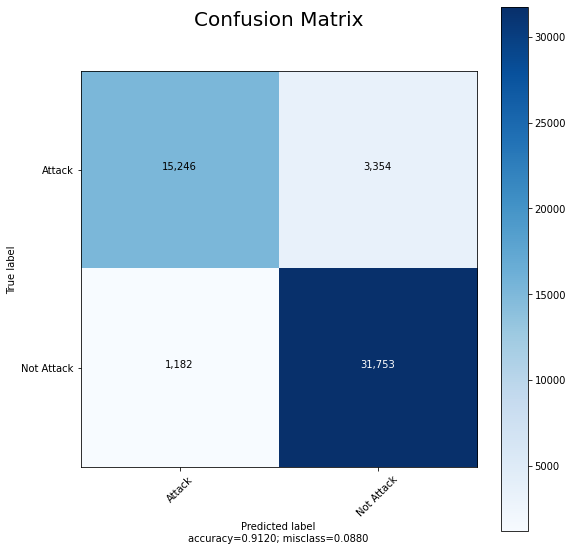

In [58]:
plot_confusion_matrix((cm),
                      normalize    = False,
                      target_names = ['Attack', 'Not Attack'],
                      title        = "Confusion Matrix")

In [59]:
#https://www.geeksforgeeks.org/confusion-matrix-machine-learning/
# Constructing the confusion matrix.

#from sklearn.metrics import confusion_matrix
#confusion_matrix(y_test, y_pred)

In [60]:
# Finding precision and recall
from sklearn.metrics import precision_score, recall_score
precision_score(y_test, y_pred)
recall_score(y_test, y_pred)

0.9044634973082292

0.9641111279793533

In [61]:
# To compute the F1 score, simply call the f1_score() function:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.933335292907322

In [62]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 


In [63]:
accuracy(cm)

0.9119821480547201

In [64]:
mse = np.mean(np.power(X_test_svd - y_pred, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test.values.reshape(1,-1)[0]})
# error_df.describe()
print()
print(np.mean(mse))
#cm = confusion_matrix(y_test, y_pred)

#print(cm)


0.4464596082110536


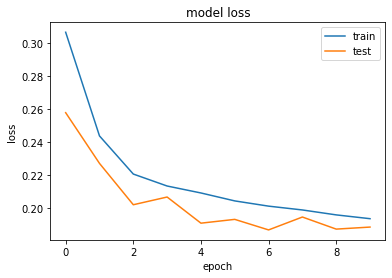

In [65]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

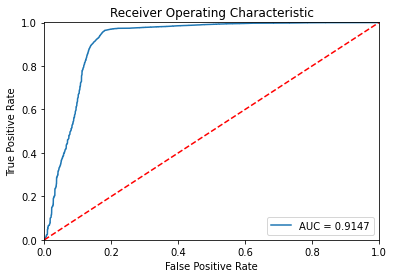

In [66]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error,pos_label=1)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Text(0.5, 1.0, 'Recall vs Precision')

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

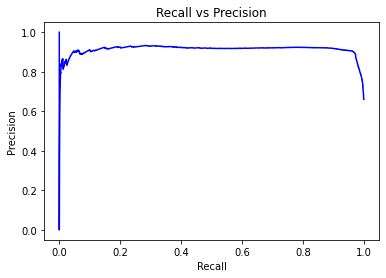

In [67]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error,pos_label=1)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

https://www.hindawi.com/journals/complexity/2019/6516253/

In [68]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.928     0.820     0.871     18600
         1.0      0.904     0.964     0.933     32935

    accuracy                          0.912     51535
   macro avg      0.916     0.892     0.902     51535
weighted avg      0.913     0.912     0.911     51535



In [ ]:
#https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [ ]:
# model metrics summary 

# TPR, Recall, Sensitivity = TP / (TP + FN)

# False positive rate (FPR),Fall-out, probability of false alarm = FP/(FP+TN) type II errror 

# False negative rate (FNR), Miss rate = FN/(TP+FN)  type I error 

# Specificity, Selectivity, True negative rate (TNR) = TN / (FP + TN)

# Prevalence = (TP+FN)/Total_Population

# Positive predictive value (PPV), Precision = TP / (TP + FP)

# False omission rate (FOR) = FN / (FN + TN)

# Positive likelihood ratio (LR+) = TPR/FPR

# Negative likelihood ratio (LR−)= FNR/TNR

# Accuracy (ACC) = (TP+TN)/Total_Population

# False discovery rate (FDR) = FP/(TP+FP)

# Negative predictive value (NPV)= TN / (FN + TN)

# Diagnostic odds ratio (DOR) = LR+/LR−

# F1 score = 2 · Precision · Recall/Precision + Recall
